In [1]:
import netket as nk
import netket.experimental as nkx

import numpy as np
from tqdm import tqdm

import jax
import jax.numpy as jnp

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from netket.operator.fermion import destroy as c
from netket.operator.fermion import create as cdag
from netket.operator.fermion import number as nc

In [4]:
from model import LogSlaterDeterminant, LogFullNeuralBackflow, CombinedModel

In [7]:
def Hubbard(t: float, U: float, 
            dimensions: list[int, int], 
            boundaries: list[bool, bool], 
            filling: tuple[int, int]) -> tuple:
    """The function generates the hilber space and the Hamiltonian for the Hubbard model

    Args:
        t (float): hopping strength
        U (float): interaction strength
        dimensions (list[int, int]): size of the lattice
        boundaries (list[bool, bool]): boundary conditions, True for periodic, False for open
        filling (tuple[int, int]): number of up and down electrons

    Returns:
        tuple: hilbert space, Hamiltonian, graph
    """
    basis_vectors = [[1,0],[0,1]]
    #Define the graph 
    graph = nk.graph.Lattice(basis_vectors=basis_vectors, extent = dimensions, pbc = boundaries)
    #Define the Hilbert space
    N = graph.n_nodes
    hi = nk.hilbert.SpinOrbitalFermions(N, s=1/2, n_fermions_per_spin=filling)
    #Define the Hamiltonian
    H = 0.0
    for (i, j) in graph.edges():
        H -= t * (cdag(hi,i,1) * c(hi,j,1) + cdag(hi,j,1) * c(hi,i,1))
        H -= t * (cdag(hi,i,-1) * c(hi,j,-1) + cdag(hi,j,-1) * c(hi,i,-1))
    for i in graph.nodes():
        H += U * nc(hi,i,1) * nc(hi,i,-1)
    return hi, H, graph

In [8]:
t = 1.0
U = 0.0
N_f = 1

Lx = 4
Ly = 4

hi, H, graph = Hubbard(t, U, [Lx, Ly], [False, False], (N_f, N_f))
#hi_full, H_full, graph_full = Hubbard(t, U, [3*Lx, Ly], [True, True], (3*N_f, 3*N_f))

In [9]:
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(H.to_sparse(), k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy:", E_gs)

Exact ground state energy: -6.47213595499958


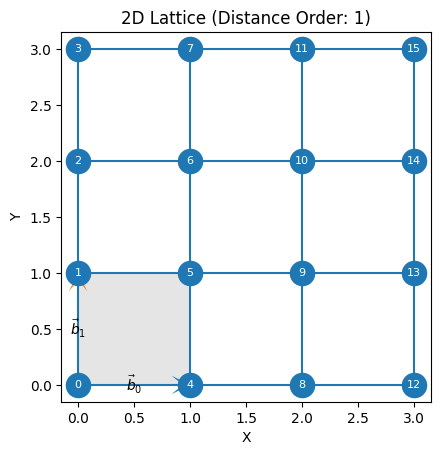

<Axes: title={'center': '2D Lattice (Distance Order: 1)'}, xlabel='X', ylabel='Y'>

In [10]:
graph.draw()

In [13]:
exchange_graph = nk.graph.disjoint_union(graph, graph, graph, graph, graph, graph)

In [6]:
# Create a neural backflow wave function
model = LogSlaterDeterminant.LogSlaterDeterminant(hi, param_dtype=complex)
# Define a Metropolis exchange sampler
sa = nkx.sampler.MetropolisParticleExchange(
    hi, graph=graph, n_chains=16, exchange_spins=False, sweep_size=64
)
# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.01)
# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=512, n_discard_per_chain=16)
# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic=True)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)
# Construct the logger to visualize the data later on
bfsd_log=nk.logging.RuntimeLog()
# Run the optimization for 300 iterations
gs.run(n_iter=300, out=bfsd_log)

100%|██████████| 300/300 [01:35<00:00,  3.14it/s, Energy=-6.47215+0.00021j ± 0.00022 [σ²=0.00002, R̂=1.0102]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [7]:
N = graph.n_nodes
model = LogFullNeuralBackflow.LogFullNeuralBackflow(hi, param_dtype=complex, hidden_units=N)
sa = nkx.sampler.MetropolisParticleExchange(
    hi, graph=graph, n_chains=16, exchange_spins=False, sweep_size=64
)
op = nk.optimizer.Sgd(learning_rate=0.05)
vstate = nk.vqs.MCState(sa, model, n_samples=512, n_discard_per_chain=16)
preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic=True)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)
bf_log=nk.logging.RuntimeLog()
gs.run(n_iter=200, out=bf_log)

100%|██████████| 200/200 [01:18<00:00,  2.56it/s, Energy=-6.471987+0.000010j ± 0.000095 [σ²=0.000005, R̂=1.0124]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [15]:
hi_help = nk.hilbert.SpinOrbitalFermions(16, s=5/2, n_fermions_per_spin=(N_f,N_f,N_f,N_f,N_f,N_f))
H_help = 0.0
for (i, j) in graph.edges():
    for sz in [-5, -3, -1, 1, 3, 5]:
        H_help -= t * (cdag(hi_help,i,sz) * c(hi_help,j,sz) + cdag(hi_help,j,sz) * c(hi_help,i,sz))
    for i in graph.nodes():
        H_help += U * nc(hi_help,i,-5) * nc(hi_help,i,-3)
        H_help += U * nc(hi_help,i,-1) * nc(hi_help,i,1)
        H_help += U * nc(hi_help,i,3) * nc(hi_help,i,5)
# We copy H_help and add some hopping terms between the different spins
H_full = H_help.copy()
for ny in range(Ly):
    i = (Lx-1)*Ly + ny
    j = ny
    H_full -= t * (cdag(hi_help,i,-5) * c(hi_help,j,-1) + cdag(hi_help,j,-1) * c(hi_help,i,-5))
    H_full -= t * (cdag(hi_help,i,-3) * c(hi_help,j,1) + cdag(hi_help,j,1) * c(hi_help,i,-3))
    H_full -= t * (cdag(hi_help,i,-1) * c(hi_help,j,3) + cdag(hi_help,j,3) * c(hi_help,i,-1))
    H_full -= t * (cdag(hi_help,i,1) * c(hi_help,j,5) + cdag(hi_help,j,5) * c(hi_help,i,1))

In [16]:
import copy

In [20]:
model_base = LogSlaterDeterminant.LogSlaterDeterminant(hi, param_dtype=complex)
#model_base = LogFullNeuralBackflow(hi, param_dtype=complex, hidden_units=16)
sys_backflow = copy.deepcopy(model_base)
env_backflow = copy.deepcopy(model_base)
model = CombinedModel.CombinedNeuralBackflow(hi_help, 
                                             sys_backflow=sys_backflow, 
                                             env_backflow=env_backflow, 
                                             param_dtype=complex)
#sa = nkx.sampler.MetropolisParticleExchange(hi_help, graph=graph, n_chains=16, exchange_spins=False, sweep_size=64)
sa =  nk.sampler.MetropolisExchange(hi_help, graph=exchange_graph, n_chains=16, sweep_size=64)
op = nk.optimizer.Sgd(learning_rate=0.01)
vstate = nk.vqs.MCState(sa, model, n_samples=512, n_discard_per_chain=16, mutable = 'sys_backflow')
#print(vstate.parameters)
preconditioner = nk.optimizer.SR(diag_shift=0.05, holomorphic=True)

/tmp/ipykernel_112123/3442615179.py:10: UserWarning: Using MetropolisExchange with SpinOrbitalFermions can yield unintended behavior.Note that MetropolisExchange only exchanges fermions according to the graph edges and might not hop fermions of all the spin sectors (see `nk.samplers.rule.FermionHopRule`). We recommend using MetropolisFermionHop.
  sa =  nk.sampler.MetropolisExchange(hi_help, graph=exchange_graph, n_chains=16, sweep_size=64)


In [21]:
gs = nk.VMC(H_full, op, variational_state=vstate, preconditioner=preconditioner)
bfsd_log=nk.logging.RuntimeLog()
gs.run(n_iter=10, out=bfsd_log,step_size=2)

100%|██████████| 10/10 [00:08<00:00,  1.15it/s, Energy=-3.61+0.08j ± 0.16 [σ²=13.84, R̂=1.0045]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

# Create a new variarional driver

In [9]:
from drivers.VMC_infinity import VMCInfinity

In [10]:
print(vstate.parameters['env_backflow']['Mdown'][0])   
print(vstate.parameters['sys_backflow']['Mdown'][0])   

[0.15319746-0.07938698j]
[0.00319222-0.40335617j]


In [14]:
gs_inf = VMCInfinity(H_full, op, variational_state=vstate, preconditioner=preconditioner)
bfsd_log=nk.logging.RuntimeLog()
gs_inf.run(n_iter=100, out=bfsd_log,step_size=10)

100%|██████████| 100/100 [01:31<00:00,  1.09it/s, Energy=-18.753+0.104j ± 0.028 [σ²=0.407, R̂=1.0097]]


(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [15]:
print(vstate.parameters['env_backflow']['Mdown'][1])
print(vstate.parameters['sys_backflow']['Mdown'][1])   

[-0.04477381+0.31500112j]
[-0.04477381+0.31500112j]


# Save and load the model

In [34]:
import flax

with open("obc_test.mpack", 'wb') as file:
  file.write(flax.serialization.to_bytes(vstate))

In [35]:
# construct a new RBM model on 10 spins
vstate_new = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# load
with open("obc_test.mpack", 'rb') as file:
  vstate_new = flax.serialization.from_bytes(vstate_new, file.read())

In [36]:
full_energy = vstate_new.expect(H)
print("Energy from the neural backflow wave function:", full_energy)

Energy from the neural backflow wave function: -8.000e+00+0.000e+00j ± 4.255e-13 [σ²=8.297e-22, R̂=1.0002]


In [17]:
vstate_new.parameters

{'Dense_0': {'bias': Array([-0.06604964, -0.05539274,  0.10638676, -0.01382882, -0.12083616,
         -0.07496182, -0.03572695, -0.18251946,  0.01450239, -0.09548088,
         -0.00045967, -0.00150087, -0.01018843, -0.18701468, -0.08020213,
          0.04238701], dtype=float64),
  'kernel': Array([[-1.23937115e-01, -1.05036308e-01,  1.45833058e-01,
           1.48723736e-01, -4.05115291e-02,  1.14236765e-01,
           6.96109528e-02,  1.04446712e-01,  9.39779807e-02,
          -7.37618761e-02,  4.52925075e-02,  9.47220663e-02,
          -1.38708323e-01,  1.95296941e-01, -7.15590837e-02,
           1.11680654e-01],
         [-2.26205944e-01,  2.18859746e-01, -2.09802866e-01,
          -2.59401031e-01,  1.76276254e-03, -7.77158833e-02,
           4.40886983e-02, -1.16810232e-01,  3.60603486e-02,
           6.22762774e-02,  5.24984725e-02, -2.60715916e-01,
           3.02344841e-01,  1.02347012e-01,  2.08403066e-02,
           7.87222552e-02],
         [ 1.97081700e-01,  1.14043421e-01, 

In [23]:
#model = LogFullNeuralBackflow(hi, hidden_units=N)
model = LogSlaterDeterminant(hi)
sampler = nkx.sampler.MetropolisParticleExchange(hi, graph=graph, n_chains=16, exchange_spins=False, sweep_size=64)
n_iters = 200
chain_length = 512//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

logger = nk.logging.RuntimeLog()

with tqdm(
    total=n_iters,
    dynamic_ncols=True,
) as pbar:
    for i in range(n_iters):
        # sample
        sampler_state = sampler.reset(model, parameters, state=sampler_state)
        samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
        
        # compute energy and gradient
        E, E_grad = estimate_energy_and_gradient(model, parameters, H.to_jax_operator(), samples)
        
        # update parameters. Try using a learning rate of 0.01
        parameters = jax.tree.map(lambda x,y: x-0.005*y, parameters, E_grad)
        
        # log energy: the logger takes a step argument and a dictionary of variables to be logged
        logger(step=i, item={'Energy':E})
        pbar.set_postfix(E=str(E))  # 格式化显示，保留 4 位小数
        pbar.update(1)

100%|██████████| 200/200 [00:47<00:00,  4.18it/s, E=-5.612-0.000j ± 0.035 [σ²=0.631]]


/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


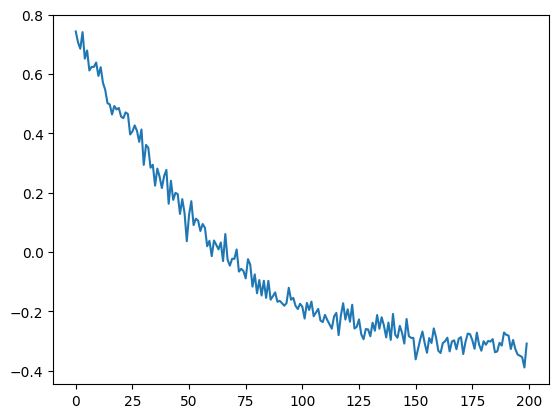

In [22]:
import matplotlib.pyplot as plt
# to plot the data, access it!
plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'])